In [2]:
#Frequency
import mne
import pandas as pd
import numpy as np
#Autoencoder
from torch import nn
import torch 
import torch.optim as optim

In [3]:
#Lectura
raw_data=mne.io.read_raw_fif("SR_10min_cleaned.fif",preload=True)

Opening raw data file SR_10min_cleaned.fif...


/tmp/ipykernel_289436/2192266951.py:2: RuntimeWarning: This filename (SR_10min_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_data=mne.io.read_raw_fif("SR_10min_cleaned.fif",preload=True)


Isotrak not found
    Range : 4608000 ... 5120000 =   9000.000 ... 10000.000 secs
Ready.
Reading 0 ... 512000  =      0.000 ...  1000.000 secs...


In [9]:
raw_data.info.keys()

dict_keys(['file_id', 'events', 'hpi_results', 'hpi_meas', 'subject_info', 'device_info', 'helium_info', 'hpi_subsystem', 'proc_history', 'meas_id', 'experimenter', 'description', 'proj_id', 'proj_name', 'meas_date', 'utc_offset', 'sfreq', 'highpass', 'lowpass', 'line_freq', 'gantry_angle', 'chs', 'dev_head_t', 'ctf_head_t', 'dev_ctf_t', 'dig', 'bads', 'ch_names', 'nchan', 'projs', 'comps', 'acq_pars', 'acq_stim', 'custom_ref_applied', 'xplotter_layout', 'kit_system_id'])

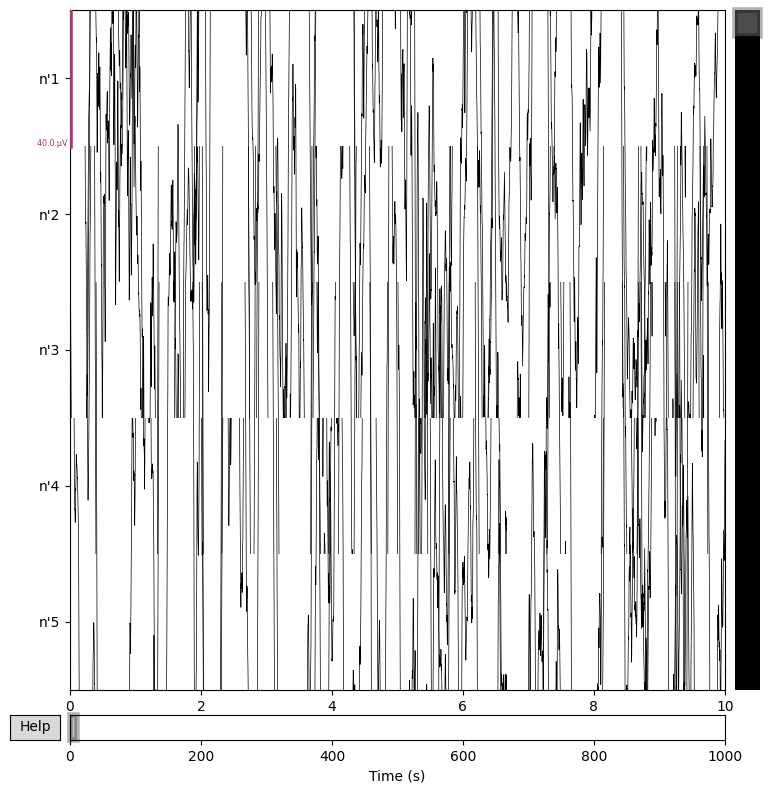

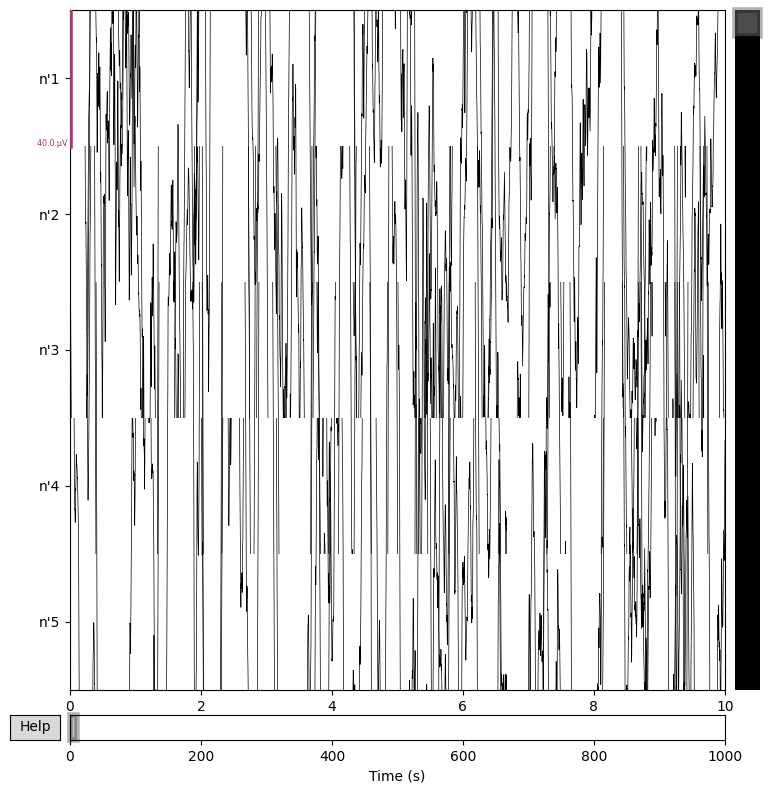

In [10]:
raw_data.plot(n_channels=5)

In [6]:
raw_data.ch_names#raw_data.info['ch_names']



fmin = 2.0  # Minimum frequency in Hz
fmax = 40.0  # Maximum frequency in Hz
tmin = 0  # Start time in seconds
tmax = raw.times[-1]

["n'1",
 "n'2",
 "n'3",
 "n'4",
 "n'5",
 "n'6",
 "n'7",
 "n'8",
 "n'9",
 "n'10",
 "n'11",
 "cc'1",
 "cc'2",
 "cc'3",
 "cc'4",
 "cc'5",
 "cc'6",
 "cc'7",
 "cc'8",
 "cc'9",
 "cc'10",
 "cc'11",
 "cc'12",
 "cc'13",
 "cc'14",
 "cc'15",
 "m'1",
 "m'2",
 "m'3",
 "m'4",
 "m'5",
 "m'6",
 "m'7",
 "m'8",
 "m'9",
 "m'10",
 "sc'1",
 "sc'2",
 "sc'3",
 "sc'4",
 "sc'5",
 "sc'6",
 "sc'7",
 "sc'8",
 "sc'9",
 "sc'10",
 "sc'11",
 "sc'12",
 "sc'13",
 "sc'14",
 "sc'15",
 "lp'1",
 "lp'2",
 "lp'3",
 "lp'4",
 "lp'5",
 "lp'6",
 "lp'7",
 "lp'8",
 "lp'9",
 "lp'10",
 "lp'11",
 "lp'12",
 "y'1",
 "y'2",
 "y'3",
 "y'4",
 "y'5",
 "y'6",
 "y'7",
 "y'8",
 "y'9",
 "y'10",
 "y'11",
 "y'12",
 "oc'1",
 "oc'2",
 "oc'3",
 "oc'4",
 "oc'5",
 "oc'6",
 "oc'7",
 "oc'8",
 "oc'9",
 "oc'10",
 "op'1",
 "op'2",
 "op'3",
 "op'4",
 "op'5",
 "op'6",
 "op'7",
 "op'8",
 "op'9",
 "op'10",
 "op'11",
 "op'12",
 "pi'1",
 "pi'2",
 "pi'3",
 "pi'4",
 "pi'5",
 "pi'6",
 "pi'7",
 "pi'8",
 "pi'9",
 "pi'10",
 "pi'11",
 "pi'12",
 "pi'13",
 "pi'14",
 "pi

In [5]:

mne.pick_channels(raw_data.info["ch_names"],include=["n'3"])

array([2])

In [4]:
a=raw_data.to_data_frame()

In [11]:
a.columns

Index(['time', 'n'1', 'n'2', 'n'3', 'n'4', 'n'5', 'n'6', 'n'7', 'n'8', 'n'9',
       ...
       'pa'3', 'pa'4', 'pa'5', 'pa'6', 'pa'7', 'pa'8', 'pa'9', 'pa'10',
       'pa'11', 'pa'12'],
      dtype='object', length=128)

In [4]:
# Create fixed-length epochs
epochs = mne.make_fixed_length_epochs(raw_data, duration=4.0, overlap=0.5)#preload=True

# You can now work with the epochs object
print(epochs)

Not setting metadata
666 matching events found
No baseline correction applied
0 projection items activated
<Epochs | 666 events (good & bad), 0 – 1.998 s (baseline off), ~130 kB, data not loaded,
 '1': 666>


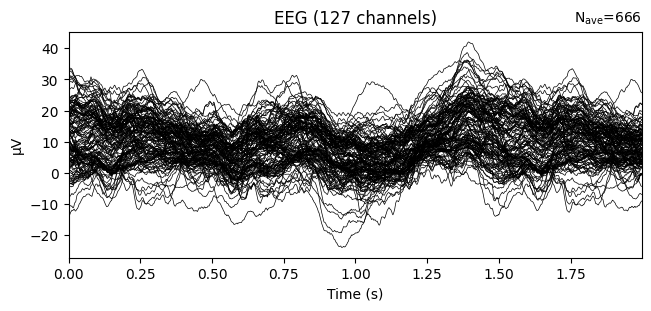

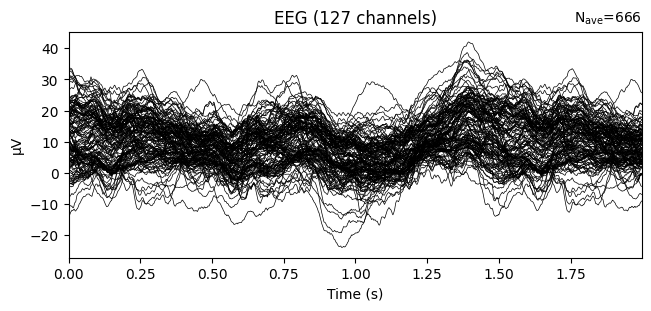

In [14]:
epochs.average().plot()

In [6]:
np.arange?

Docstring:
arange([start,] stop[, step,], dtype=None, *, device=None, like=None)

Return evenly spaced values within a given interval.

``arange`` can be called with a varying number of positional arguments:

* ``arange(stop)``: Values are generated within the half-open interval
  ``[0, stop)`` (in other words, the interval including `start` but
  excluding `stop`).
* ``arange(start, stop)``: Values are generated within the half-open
  interval ``[start, stop)``.
* ``arange(start, stop, step)`` Values are generated within the half-open
  interval ``[start, stop)``, with spacing between values given by
  ``step``.

For integer arguments the function is roughly equivalent to the Python
built-in :py:class:`range`, but returns an ndarray rather than a ``range``
instance.

When using a non-integer step, such as 0.1, it is often better to use
`numpy.linspace`.

See the Warning sections below for more information.

Parameters
----------
start : integer or real, optional
    Start of interval.

: 

In [11]:
power = epochs.compute_tfr(
    method="multitaper",
    freqs=np.arange(5.0,20.0,3.0),
    #n_cycles=n_cycles,
    #time_bandwidth=time_bandwidth,
    return_itc=False,
    average=True,
)
#plot.set_title("TFR")
# Plot results. Baseline correct based on first 100 ms.

# power.plot(
#     [0],
#     baseline=(0.0, 0.1),
#     mode="mean",
#     #vlim=(vmin, vmax),
#     #axes=ax,
#     show=False,
#     colorbar=False,
# )

Using data from preloaded Raw for 666 events and 1024 original time points ...


: 

In [6]:
help(power.plot)

NameError: name 'power' is not defined

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim, num_layers=1):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        # LSTM Encoder
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, input_size)
    
    def encode(self, x):
        # x is (batch, seq_len, input_size)
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n[-1]  # Get the last layer's hidden state
        
        # Compute mu and logvar
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + std * eps
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, seq_len):
        # z is (batch_size, latent_dim)
        # We repeat the latent vector across the sequence length
        z = z.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Pass through LSTM decoder
        out, _ = self.decoder_lstm(z)
        out = self.fc_out(out)
        return out
    
    def forward(self, x):
        # x is (batch, seq_len, input_size)
        seq_len = x.size(1)
        
        # Encode
        mu, logvar = self.encode(x)
        
        # Reparameterize to get latent vector z
        z = self.reparameterize(mu, logvar)
        
        # Decode to reconstruct the time series
        recon_x = self.decode(z, seq_len)
        return recon_x, mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (e.g., MSE)
    recon_loss = nn.MSELoss()(recon_x, x)
    
    # KL Divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss

# Example usage:
input_size = 1      # Number of features in the time series
hidden_size = 64    # Hidden size of LSTM
latent_dim = 16     # Size of the latent space
num_layers = 1      # Number of LSTM layers

# Instantiate the model
vae = VAE(input_size, hidden_size, latent_dim, num_layers)

# Dummy time series data (batch_size, seq_len, input_size)
x = torch.randn(32, 50, input_size)  # batch of 32, sequence length of 50

# Forward pass
recon_x, mu, logvar = vae(x)

# Compute loss
loss = vae_loss(recon_x, x, mu, logvar)

# Print the loss
print("VAE Loss:", loss.item())


VAE Loss: 3.0795257091522217


In [15]:
torch.randn(32,50)


tensor([[ 0.6071,  0.6792, -2.1073,  ..., -0.7371, -1.4900,  0.8283],
        [-0.8422,  0.7141,  0.5781,  ..., -1.2129, -1.0864, -0.1742],
        [ 1.4556, -2.1567, -1.5981,  ..., -0.2752, -0.4059,  0.2436],
        ...,
        [ 0.2959, -0.2503, -0.5724,  ...,  0.3185,  0.4589, -1.1182],
        [-0.4760, -0.3100, -1.1028,  ..., -0.6189,  0.1253, -1.3486],
        [ 0.4291, -0.3045, -0.9726,  ...,  1.1347, -0.3225, -0.7390]])